# Dynamic model

In [1]:
#| echo: false

# Ignore warning about depreciated modules
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [6]:
#| echo: false

# Import path of model
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, './src')

In [3]:
#| echo: false

# Enable interactive plotting
%matplotlib ipympl

## Conceptual diagram

![Conceptual diagram of shoot FSPM (not final version, some errors)](images/shoot_FSPM_conceptual_diagram_alone.jpg "Conceptual diagram")

The main stem grows according to the crop model's plant height. At the end of the growth of an internode, a leaf appears. The appearance of a leaf is triggered by fixed phyllochron (different for tillers?).  

Cf Fournier et al, 2005 for leaf elongation 

The angle of the leaf with its axis is leaf-age dependent. The leaf blade curvature depends on the angle with the axis and the leaf length.  

The reproductive organs appear from a given thermal time, when the leaves have stopped growing. 

Leaf senescence is constrained by crop model, as it has a direct influence on LAI (green LAI vs. yellow LAI ?).  

The branching pattern is set (Tillers (Zhu et al., 2015)). 

## Time-dependent parametrization of leaf area

$$ \mathcal{A_normalized} = 2 * |\int_{0}^{1} \mathcal{C}(s(u))ds(u)| $$
$$ \mathcal{A} = \mathcal{A_scaled} = 2 * w * |\int_{0}^{L} \mathcal{C}(\frac{s(u)}{L})d\frac{s(u)}{L}| $$
$$ \frac{d\mathcal{A}}{dt} = 2 * w * |\int_{ds(t)/L} \mathcal{C}(\frac{s(u)}{L})d\frac{s(u)}{L}| $$

- $\mathcal{A}$ : final leaf area (or surface), in $cm^2$ (given by crop model)
- $\frac{d\mathcal{A}}{dt}$ : gain in area, in $cm^2$, for a given leaf for a given time step $dt$ (given by crop model)  
- $\mathcal{C}$ : curve of the evolution of the leaf width along the leaf, **from tip to base** (literature/expert knowledge/observation)
- $s(t)$ : curvilinear abscissa of the midrib, in $cm$, as a function of thermal time $t$, such that: $ ds(t) = \sqrt{(dx(t))^2+(dy(t))^2} $ (computed from leaf curvature)
- $w$ : final maximal width of the leaf, in $cm$ (to fix/vary within a reasonable range)
- $L$ : final length of the leaf, in $cm$ (to fix/vary within a reasonable range)
- $t$ : thermal time, in $^oC.day$


The objective is to find, for each growing leaf, at each time step, and for a given leaf area provided to the leaf $\frac{d\mathcal{A}}{dt}$, how much length $ds(t)$ is added to the leaf.

$$ \frac{d\mathcal{A}}{dt} = 2w |\int_{s(t-1)/L}^{s(t)/L} \mathcal{C}(\frac{s(u)}{L})d\frac{s(u)}{L}| $$

According to the Fundamental Theorem of Calculus, $\mathcal{C}$ being at least $C^0$ on $[0,L]$, $F$ being the antiderivative of $\mathcal{C}$, we can write:

$$ \frac{d\mathcal{A}}{dt} = 2w (|F(\frac{s(t)}{L}) - F(\frac{s(t-1)}{L})|) $$

$$ F(\frac{s(t)}{L}) = |\frac{1}{2w} \frac{d\mathcal{A}}{dt} + F(\frac{s(t-1)}{L})| $$

Knowing the other variables, we know have to determine $s(t)$ at thermal time $t$.

In [4]:
#| echo: false
# drawing

## Apparition and growth of phytomers (stem and leaf)

The height of the plant/canopy (here we consider the height of the main stem) is given by the crop model.  
The plastochron (i.e. leaf initiation rate, in $leaf^{-1}$) is the time interval between two successive leaves produced at the SAM.  
The phyllochron (i.e. leaf emergence rate, in $leaf^{-1}$) is the time interval between two successive leaves emerging from the top of the former leaf sheath.  
The time for a leaf to grow is roughly between 1.5 and 2 phyllochrons.  
We consider a linear (rough approximation of beta function) growth for the leaf.  

- $\phi$ : phyllochron, in $^oC.day.leaf^{-1}$ (literature)
- cur_len_int : current length of growing internodes
- fin_len_int : final length of internodes, in $cm$ (literature, bell shaped model too ?)
- height : plant height, in $cm$ (given by crop model)
- $[s(t)]$ : current length of growing leaves, in $cm$ (computed before)
- fin_len_leaf : final length of leaves, in $cm$  (bell shaped model)
- leaf expansion duration, as $x * \phi$, in $^oC.day$ (literature, cf Clerget et al., 2008, etc)  

Cf Fournier et al, 2005; Stewart and Dwyer, 1993; Skinner and Nelson, 1995  



From crop model: 

## Modifying the MTG of a growing plant

There are several ways to conceive the MTG for a growing plant.  

At each thermal time step, the turtle visits each element and adds a value to a time series for each (almost) properties of the MTG.   

**OR**   

At each thermal time step, the MTG is replicated and the growing elements ar modified, and new elements are added if needed.  

In [22]:
## Imports

# from installed packages
import numpy as np
import matplotlib.pyplot as plt
from openalea.plantgl.all import Vector3

# from ./src
from cereals_leaf import parametric_leaf

## Code for generating a parametric leaf for a cereal 
pl=parametric_leaf(nb_segment=10, insertion_angle=40, scurv=0.7, curvature=90, alpha=-2.3)
pl

(array([0.00749877, 0.08470364, 0.13238738, 0.20096865, 0.28491199,
        0.32926371, 0.42131892, 0.52548588, 0.60150059, 0.72220515,
        0.75800434, 0.82680868]),
 array([-0.00446052,  0.11023448,  0.16375474,  0.22645733,  0.28536742,
         0.30959196,  0.3455314 ,  0.3625188 ,  0.35762971,  0.31394208,
         0.29066803,  0.22892874]),
 array([0.        , 0.13825894, 0.20993988, 0.30286461, 0.40541647,
        0.45595262, 0.55477471, 0.66031772, 0.73648949, 0.86485694,
        0.90755663, 1.        ]),
 array([0.738203  , 0.91365864, 0.96981854, 1.00337648, 0.99197869,
        0.97093695, 0.90233574, 0.77807322, 0.64551957, 0.3668271 ,
        0.26649993, 0.        ]))

In [27]:
pl = (pl[0][::-1], pl[1][::-1], pl[2], pl[3])

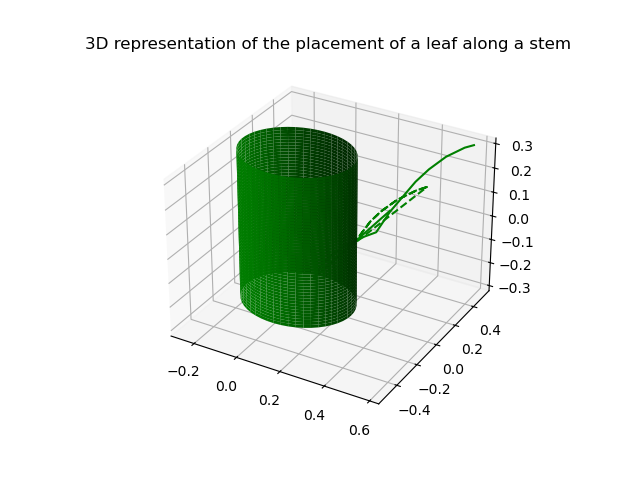

In [29]:
## Imports

# from installed packages
from math import pi, cos, sin, radians
import matplotlib.tri as mtri
import openalea.plantgl.all as pgl

# from ./src
# from cereals_leaf import arrange_leaf
# or 
from geometry import arrange_leaf
from fitting import leaf_to_mesh_2d

## Code for placing a leaf against a stem element (here a cylinder), with a given inclination
stem_diameter=0.5
inclination=1

al=arrange_leaf(leaf=pl, 
                stem_diameter=stem_diameter, 
                inclination=inclination, 
                relative=True)

pourc = 0.5
idx_cut = int(pourc*len(al[0]))
al = (al[0][:idx_cut], al[1][:idx_cut], al[2][:idx_cut], al[3][:idx_cut])


x=al[0]
y=al[1]
s=al[2]
r=al[3]

pts,ind=leaf_to_mesh_2d(x, y, r)

xs=[pt[0] for pt in pts]
ys=[pt[1] for pt in pts]
zs=[pt[2] for pt in pts]
    
X,Y=np.meshgrid(xs, ys)

tri=mtri.Triangulation(xs, ys)

fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.plot(xs,ys,zs,c="green")
ax.plot([xs[0],xs[0]],[ys[0],-ys[0]],[0,0],c="green")
ax.plot(xs,np.zeros(len(ys)),zs,c="green",ls="dashed")

radius=stem_diameter/2
z=np.linspace(-zs[-1], zs[-1])
theta=np.linspace(0, 2*np.pi)
theta_grid, z_stem=np.meshgrid(theta, z)
x_stem=radius*np.cos(theta_grid)
y_stem=radius*np.sin(theta_grid)

ax.plot_surface(x_stem, y_stem, z_stem, color="green")

ax.set_title("3D representation of the placement of a leaf along a stem")

plt.show()

In [25]:
pl

(array([0.82680868, 0.75800434, 0.72220515, 0.60150059, 0.52548588,
        0.42131892, 0.32926371, 0.28491199, 0.20096865, 0.13238738,
        0.08470364, 0.00749877]),
 array([ 0.22892874,  0.29066803,  0.31394208,  0.35762971,  0.3625188 ,
         0.3455314 ,  0.30959196,  0.28536742,  0.22645733,  0.16375474,
         0.11023448, -0.00446052]),
 array([1.        , 0.90755663, 0.86485694, 0.73648949, 0.66031772,
        0.55477471, 0.45595262, 0.40541647, 0.30286461, 0.20993988,
        0.13825894, 0.        ]),
 array([0.738203  , 0.91365864, 0.96981854, 1.00337648, 0.99197869,
        0.97093695, 0.90233574, 0.77807322, 0.64551957, 0.3668271 ,
        0.26649993, 0.        ]))

## Next steps

- Constrains from crop model
- Bending dynamics of leaves and tillers